# Binary Planet Suppression: Imports and data gathering

In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

mpl.rc('lines',linewidth = 1.5)
mpl.rc('font',size = 12)
mpl.rc('axes',labelsize = 14, linewidth=1.25)
mpl.rc('xtick',labelsize = 14)
mpl.rc('ytick',labelsize = 14)
# enable math fonts
mpl.rc('mathtext', default = 'regular')

import pickle

import pandas as pd

## Data from Kepler survey

Our goal here is just to get parallaxes for the KOIs. I only need these for the Sullivan binary catalog later, because for those stars I will need to convert angular separations to distances.

### First up the KOI catalog, downloaded from NExSci

In [2]:
# read in KOI catalog, massage the name strings
kois = Table.read('/Users/enewton/DATA_DIR/nexscikois_2025.05.12_09.55.50.vot').to_pandas()
kois['kepid'] = kois['kepid'].astype('int64')
kois['KOI'] = kois['kepoi_name'].str.extract(r'K0*(\d+)\.\d+')[0].astype(int)

print("Length of KOI table: ", len(kois))
kois[['kepid','KOI', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_prad']].head()

Length of KOI table:  9564


,kepid,KOI,kepoi_name,kepler_name,koi_disposition,koi_prad
0,11446443,1,K00001.01,Kepler-1 b,CONFIRMED,13.04
1,10666592,2,K00002.01,Kepler-2 b,CONFIRMED,16.10
2,10748390,3,K00003.01,Kepler-3 b,CONFIRMED,4.82
3,3861595,4,K00004.01,Kepler-1658 b,CONFIRMED,12.94
4,8554498,5,K00005.01,,CANDIDATE,7.14


In [3]:
kois.columns

Index(['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss',
       'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1',
       'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2',
       'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth',
       'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1',
       'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol',
       'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num',
       'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2',
       'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad',
       'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag', 'KOI'],
      dtype='object')

### Now Bedell's Gaia-Kepler fun crossmatches

First we'll look at the 1-1 matches, `kepler_dr3_good.fits`. 

In [4]:
# Read in the KIC from Bedell's Gaia-Kepler fun (1-1 matches only, all entries are unique)
kic = Table.read('/Users/enewton/DATA_DIR/kepler_dr3_good.fits').to_pandas()
kic['bedell_cat'] = 'good'
print("Length of KICxGaia table: ", len(kic))

# Cross match KOIs and KIC 
kois_x_kic = kois.merge(kic[['kepid', 'parallax','parallax_over_error','source_id','kepler_gaia_ang_dist',
                             'phot_g_mean_mag','ruwe','bedell_cat']], how='left', on='kepid')
print("Length of KOIsxKICxGaia table: ", len(kois_x_kic))

# note: converts source_id to float because of NaNs

Length of KICxGaia table:  196762
Length of KOIsxKICxGaia table:  9564


In [5]:
kic.columns

Index(['kepid', 'ra_kic', 'dec_kic', 'source_id', 'random_index', 'ra', 'dec',
       'parallax', 'parallax_error', 'parallax_over_error', 'pmra',
       'pmra_error', 'pmdec', 'pmdec_error', 'astrometric_params_solved',
       'pseudocolour', 'pseudocolour_error', 'ipd_frac_multi_peak',
       'ipd_frac_odd_win', 'ruwe', 'phot_g_mean_flux_over_error',
       'phot_g_mean_mag', 'phot_bp_mean_flux_over_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux_over_error', 'phot_rp_mean_mag',
       'phot_bp_rp_excess_factor', 'bp_rp', 'radial_velocity',
       'radial_velocity_error', 'rv_nb_transits', 'rv_expected_sig_to_noise',
       'rv_renormalised_gof', 'rv_chisq_pvalue', 'phot_variable_flag', 'l',
       'b', 'in_qso_candidates', 'in_galaxy_candidates', 'non_single_star',
       'has_xp_continuous', 'has_xp_sampled', 'has_rvs',
       'has_epoch_photometry', 'has_epoch_rv', 'has_mcmc_gspphot',
       'has_mcmc_msc', 'in_andromeda_survey', 'teff_gspphot', 'logg_gspphot',
       'mh_gs

Now we'll move onto the larger cross-match Megan did, based on larger angular distances. I determined I needed the 4 arcsec table (too many stars were outside the 1 arcsec match). My by-eye checking of several entries on Simbad indicates that the additionally matches are at least in agreement with what Simbad thinks. They're all pretty faint, seem to be distant M dwarfs. Would be ideal to check the colors actually make sense, but that's beyond what's needed for this analysis.

In [6]:
# Read in the bigger cross-match to find the missing Gaia matches
kic4as = Table.read('/Users/enewton/DATA_DIR/kepler_dr3_4arcsec.fits').to_pandas()
kic4as['bedell_cat'] = '4as'

# Fill in the stars with missing Gaia matches
missing_mask = kois_x_kic['source_id'].isnull()
missing_rows = kois_x_kic.loc[missing_mask, 'kepid'].unique()

# Subset of kic1as those missing parallaxes
kic4as_subset = kic4as[kic4as['kepid'].isin(missing_rows)]

# Hope the closest match is the best match
kic4as_first = kic4as_subset.sort_values(['kepid','kepler_gaia_ang_dist']).groupby('kepid').first().reset_index()

# Columns coming from kic1as_first to fill into kic_merged
columns_to_fill = ['parallax', 'parallax_over_error','source_id', 'kepler_gaia_ang_dist', 'phot_g_mean_mag','ruwe','bedell_cat']

# Merge relevant kic1as columns with kic_updated
k1 = kic4as_first[['kepid'] + columns_to_fill]
temp = kois_x_kic.merge(k1, how='left', on='kepid', suffixes=('', '_4as'))

for col in columns_to_fill:
    temp[col] = temp[col].fillna(temp[col + '_4as']) # fill column
    temp.drop(columns=[col + '_4as'], inplace=True) # drop temp column

# Temp now has the filled columns
kois_x_kic4as = temp
    
kois_x_kic4as.loc[kois_x_kic4as['parallax'] < 0, 'parallax'] = np.nan

kois_x_kic4as[columns_to_fill][missing_mask].head() #2126519126656859904

print("Length of updated KOIsxKICxGaia table: ", len(kois_x_kic4as))
print("Previously had missing matches: ", sum(missing_mask))
print("Now have missing matches: ", sum(kois_x_kic4as['source_id'].isnull()))
print("Now have missing number of parallaxes: ", sum(kois_x_kic4as['parallax'].isnull()))

Length of updated KOIsxKICxGaia table:  9564
Previously had missing matches:  142
Now have missing matches:  2
Now have missing number of parallaxes:  172


### Save the results

In [7]:
kois_x_kic4as[['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
               'koi_pdisposition', 'koi_period', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2',
               'koi_kepmag', 'KOI', 
               'source_id', 'parallax', 'parallax_over_error', 'kepler_gaia_ang_dist',
               'phot_g_mean_mag', 'ruwe','bedell_cat']].to_pickle('kois+gaia.pkl')


## Data from Sullivan et al.

### Starting with the published tables

In [8]:
#https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/AJ/168/129/table5
sullivan = Table.read('sullivan2024_planets.vot').to_pandas()

# https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=J/AJ/168/129/sample
stars = Table.read('sullivan2024_stars.vot').to_pandas() 

planets = sullivan.merge(stars, how='left', on='KOI')
planets['KOI'] = planets['KOI'].astype(int)

In [9]:
print("Length of sullivan: ", len(sullivan), " (This is the number of planets in the binary sample)")
sullivan.head()

Length of sullivan:  404  (This is the number of planets in the binary sample)


,KOIpl,Rppri,E_Rppri,e_Rppri,Rpsec,E_Rpsec,e_Rpsec,Rpkep,e_Rpkep,Teqpri,...,e_Spri,Ssec,E_Ssec,e_Ssec,Skep,e_Skep,KOI,Simbad,_RA,_DE
0,42.009998,2.28,0.14,0.14,4.89,0.32,0.33,2.43,0.12,873,...,6.320000,15.800000,0.50,0.950000,132.94,20.74,0042,Simbad,283.15067,45.13982
1,112.010002,3.55,0.72,0.72,4.74,0.98,0.98,2.75,0.39,571,...,1.950000,8.590000,0.83,0.820000,15.17,6.00,0112,Simbad,295.64868,48.49555
2,112.019997,1.49,0.29,0.30,1.98,0.38,0.40,1.16,0.17,1371,...,64.290001,283.489990,27.43,27.200001,500.46,197.96,0112,Simbad,295.64868,48.49555
3,162.009995,3.72,0.86,0.83,4.50,0.93,0.92,3.11,0.45,848,...,15.300000,55.450001,11.28,11.620000,100.09,42.19,0162,Simbad,295.16377,43.96305
4,163.009995,2.71,0.26,0.26,3.09,0.30,0.29,2.08,0.14,676,...,2.790000,38.200001,2.17,2.080000,42.07,9.84,0163,Simbad,288.06760,42.35537


In [10]:
print("Length of stars: ", len(stars), " (This is the number of stars/planetary SYSTEMS in the binary sample)")
print("Confirm total number of planets: ", sum(stars['Np']), " (This is the sum of the number of planets column)")
stars.head()

Length of stars:  286  (This is the number of stars/planetary SYSTEMS in the binary sample)
Confirm total number of planets:  404  (This is the sum of the number of planets column)


,NIRC2,KOI,Np,Sep,_tab1_5,rmag,SNR,dmi,e_dmi,dmLP600,...,fcorr-s,E_fcorr-s,e_fcorr-s,Source,K16,F17,Simbad,_RA,_DE,recno
0,*,0042,1,1.66,2022-07-13,9.33,2095,NaN,NaN,3.04,...,2.01,0.10,0.09,1,1,1,Simbad,283.15067,45.13982,1
1,*,0112,2,0.11,2023-09-24,12.74,521,NaN,NaN,NaN,...,1.67,0.29,0.21,2,1,1,Simbad,295.64868,48.49555,2
2,*,0162,1,0.29,2022-10-21,13.77,297,NaN,NaN,0.81,...,1.42,0.26,0.20,2,0,1,Simbad,295.16377,43.96305,3
3,*,0163,1,1.22,2023-09-10,13.49,324,NaN,NaN,0.36,...,1.48,0.11,0.09,2,0,1,Simbad,288.06759,42.35534,4
4,*,0165,1,0.28,2023-09-25,13.90,257,NaN,NaN,NaN,...,2.07,0.18,0.17,2,0,1,Simbad,292.48693,46.19620,5


In [11]:
# massage the KOI names

koi = planets['KOIpl'].astype(float)

scaled = (koi * 100).round().astype(int)            # e.g. 4201 for 42.01
whole = (scaled // 100).astype(str).str.zfill(5)    # zero-pad whole part to 5 digits
frac2 = (scaled % 100).astype(str).str.zfill(2)     # two-digit fractional part

planets['kepoi_name'] = 'K' + whole + '.' + frac2

In [12]:
print("Length of planets after merging sullivan+stars: ", len(planets))
planets[['KOIpl','KOI','kepoi_name']].head()

Length of planets after merging sullivan+stars:  404


,KOIpl,KOI,kepoi_name
0,42.009998,42,K00042.01
1,112.010002,112,K00112.01
2,112.019997,112,K00112.02
3,162.009995,162,K00162.01
4,163.009995,163,K00163.01


### Getting distances by any means necessary for Sullivan sample

Most of these are wide enough that Gaia has totally fine parallaxes. Some are too close. Kendall got distance estimates for these (not published, but given to me in the derived_star table) that I'll use when I have to.

Start with just cross-matching to the KOIs+Gaia list I just created.

In [13]:
# read in the file I created above
with open('kois+gaia.pkl', 'rb') as file:
       kgx = pickle.load(file)
    
# merging Kendall's catalog with KOIs+gaia match
s24_x_gaia = planets.merge(kgx, how='left', on=['kepoi_name','KOI'])

# doing distance and SepAU calculation
s24_x_gaia['distance'] = 1000./s24_x_gaia['parallax']

print("In the Sullivan sample, we have missing number of parallaxes: ", sum(s24_x_gaia['parallax'].isnull()))

In the Sullivan sample, we have missing number of parallaxes:  42


The rest should have distances here

In [14]:
extra = pd.read_csv(open('derived_star.tex', 'r'), sep='&')
extra['KOI'] = extra['sname'].astype('int64')

#s24_x_gaia.merge(extra, how='left', )

In [15]:
binary_db = s24_x_gaia.merge(extra, how='left', on='KOI', suffixes=['','_extra'])


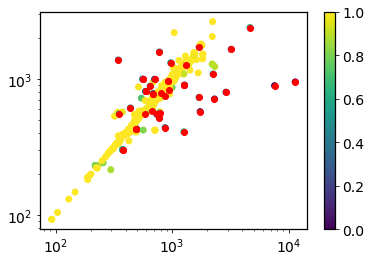

In [22]:
plt.scatter(binary_db['distance'], binary_db['distance_extra'], c=binary_db['parallax_over_error'], vmin=1, vmax=10)
plt.scatter(binary_db['distance'][binary_db['parallax_over_error']<7], 
            binary_db['distance_extra'][binary_db['parallax_over_error']<7],
           c='r')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

In [26]:
replace = binary_db['parallax_over_error'] < 7
binary_db.loc[replace, 'distance'] = binary_db['distance_extra'][replace]

binary_db['SepAU'] = binary_db['distance']*binary_db['Sep']

binary_db.to_pickle('kendall+kepler.pkl')

# Assessing the compiled catalogs

Making sure things look right

### Make my catalogs

In [1]:
# read in Kendall's catalog, xmatched to all the stuff from Kepler that I need
with open('kendall+kepler.pkl', 'rb') as file:
       db = pickle.load(file)

# read in my kois table
with open('kois+gaia.pkl', 'rb') as file:
        kois = pd.read_pickle(file)

# remove the studied binaries from the all_KOI catalog
# also remove false positives
# and non-positive parallaxes
kois_less = kois[ (~kois['kepoi_name'].isin(db['kepoi_name'])) & 
                 (kois['koi_disposition']!='FALSE POSITIVE') & 
                 (kois['parallax']>0)]

NameError: name 'pickle' is not defined

### Radius distribution of all KOIs (less the binaries)

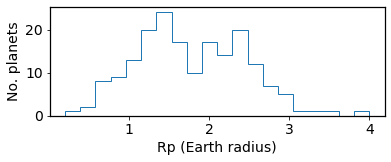

In [29]:

kgood = (kois_less['koi_prad_err1']/kois_less['koi_prad'] < 0.05) & \
    (kois_less['koi_prad_err2']/kois_less['koi_prad'] < 0.05) & \
    (kois_less['koi_period'] < 100) 
plt.figure(figsize=(6,2))
plt.hist(kois_less['koi_prad'][kgood], range=[0.2,4], bins=20, histtype='step')
plt.xlabel('Rp (Earth radius)')
plt.ylabel('No. planets')
plt.show()

Text(0, 0.5, 'Rp (Earth rad)')

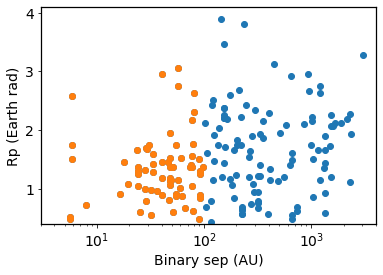

In [30]:
# trying to confirm this is right... 
# seems good, prob a bit dif b/c using different planet param database


good = (db['e_Rpkep']/db['Rpkep'] < 0.15) & (db['koi_period']<100)
close = db['SepAU']<100

plt.scatter(db['SepAU'][good], db['Rpkep'][good])
plt.scatter(db['SepAU'][good & close], db['Rpkep'][good & close])
plt.ylim(0.4,4.1)
plt.xlim(3, 4000)
plt.xscale('log')
plt.xlabel('Binary sep (AU)')
plt.ylabel('Rp (Earth rad)')

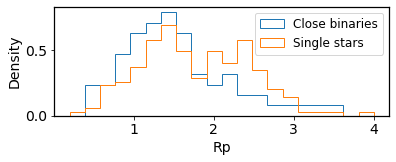

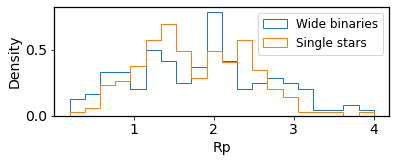

In [32]:
#kendall assumes they orbit primary stars which is prob mostly true based on nathanael's work?

# planets with good radii in binary systems with rho<100 au and planet period < 100 days
plt.figure(figsize=(6,2))
plt.hist(db['Rppri'][good & close], range=[0.2,4], bins=20, 
         density=True, histtype='step',
        label='Close binaries')

# compared to the kois that are at least not definite binaries with good radii and per<100 days
plt.hist(kois_less['koi_prad'][kgood], range=[0.2,4], bins=20, 
         density=True, histtype='step',
        label='Single stars')

plt.legend()
plt.xlabel('Rp')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(6,2))
plt.hist(db['Rppri'][good & ~close], range=[0.2,4], bins=20, 
         density=True, histtype='step',
        label='Wide binaries')
plt.hist(kois_less['koi_prad'][kgood], range=[0.2,4], bins=20, 
         density=True, histtype='step',
        label='Single stars')

plt.legend()
plt.xlabel('Rp')
plt.ylabel('Density')
plt.show()


In [ ]:
kgx.columns